In [1]:
# -----------------------------------------------------------
# IMPORT ALL NECESSARY MODULES
# -----------------------------------------------------------

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline


In [2]:
df = pd.read_csv('training_df_small.csv')
df['timestamp'] = pd.to_datetime(df['start_date'])
df = df.set_index('timestamp')
df = df.sort_index()
df.drop(columns=['start_date'], inplace=True)
df.head()

,cpu_usage,gpu_wrk_util,avg_mem,max_mem,avg_gpu_wrk_mem,max_gpu_wrk_mem,runtime
timestamp,,,,,,,
1970-01-28 15:32:43,35.636364,0.080000,2.060832,32.796875,2.447969,4.208984,114.0
1970-01-29 16:01:19,51.043478,13.692308,0.780721,1.835938,0.441632,0.993164,104.0
1970-01-29 16:05:16,59.483871,24.029412,3.403646,37.934570,2.487621,6.723633,161.0
1970-01-30 11:54:59,8021.102453,77.019231,4.084847,37.093750,6.160750,6.541992,10397.0
1970-01-30 14:50:21,81.285714,42.958333,4.360521,37.631836,3.374715,6.723633,114.0


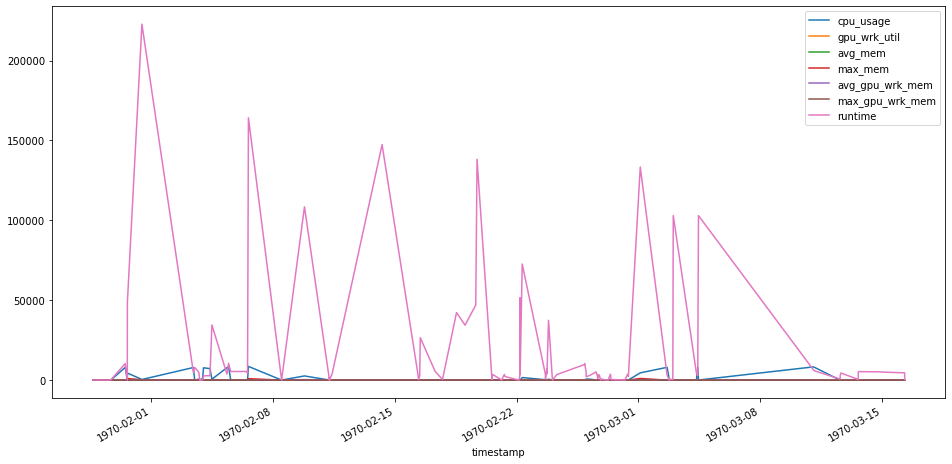

In [3]:
df.plot(figsize=(16, 8))
plt.show()

In [4]:
# -----------------------------------------------------------
# CREATE TRAIN-TEST SPLIT (80:20)
# -----------------------------------------------------------
TRAIN_LENGTH = round(len(df) * 0.8)
TEST_LENGTH = len(df) - TRAIN_LENGTH
train = df.iloc[0:TRAIN_LENGTH]
test = df[TRAIN_LENGTH:]


In [5]:
train

,cpu_usage,gpu_wrk_util,avg_mem,max_mem,avg_gpu_wrk_mem,max_gpu_wrk_mem,runtime
timestamp,,,,,,,
1970-01-28 15:32:43,35.636364,0.080000,2.060832,32.796875,2.447969,4.208984,114.0
1970-01-29 16:01:19,51.043478,13.692308,0.780721,1.835938,0.441632,0.993164,104.0
1970-01-29 16:05:16,59.483871,24.029412,3.403646,37.934570,2.487621,6.723633,161.0
1970-01-30 11:54:59,8021.102453,77.019231,4.084847,37.093750,6.160750,6.541992,10397.0
1970-01-30 14:50:21,81.285714,42.958333,4.360521,37.631836,3.374715,6.723633,114.0
...,...,...,...,...,...,...,...
1970-02-27 15:47:57,124.901235,107.771084,6.019778,36.113281,5.840985,6.817383,401.0
1970-02-27 16:39:44,66.450000,98.695652,3.183949,36.982422,2.651070,6.729492,103.0
1970-02-27 16:41:29,125.064935,114.544304,6.457649,38.242188,5.697575,6.817383,382.0


In [6]:
# -----------------------------------------------------------
# SCALING VALUES
# -----------------------------------------------------------

# https://cnvrg.io/pytorch-lstm/

mm_scaler = MinMaxScaler()
ss_scaler = StandardScaler()
X_ss = pd.DataFrame(ss_scaler.fit_transform(train))
y_mm = pd.DataFrame(mm_scaler.fit_transform(test))


## Split the Dataset

Now the dataset gets split into test and training dataset.

*Note: To later be able to convert the dataset into Tensors, it is necessary to convert them to numpy arrays via `.to_numpy()`*.

In [7]:
TRAIN_SPLIT: int = 23
TEST_SPLIT = 10

X_train = X_ss[:TRAIN_SPLIT].to_numpy()
X_test = X_ss[TEST_SPLIT:].to_numpy()

y_train = y_mm[:TRAIN_SPLIT].to_numpy()
y_test = y_mm[TEST_SPLIT:].to_numpy()

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (23, 7) (23, 7)
Testing Shape (81, 7) (13, 7)


Training Shape (20, 7) (20, 7)
Testing Shape (71, 7) (3, 7)


In [8]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [9]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

## Reshaping to Rows, Timestamps and Features


In [10]:
X_train_tensors_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([23, 1, 7]) torch.Size([23, 7])
Testing Shape torch.Size([81, 1, 7]) torch.Size([13, 7])


## Create the LSTM Model

In [11]:
class LSTM(nn.Module):

    def __init__(self, num_classes: int, input_size: int, hidden_size: int, num_layers: int, seq_length: int) -> None:
        super(LSTM, self).__init__()
        self.num_classes: int = num_classes
        self.input_size: int = input_size
        self.hidden_size: int = hidden_size
        self.num_layers: int = num_layers
        self.seq_length: int = seq_length

        # long-short term memory layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True)

        # first fully connected layer
        self.fc_1 = nn.Linear(hidden_size, 128)
        # second fully connected layer
        self.fc_2 = nn.Linear(128, num_classes)
        # activation function
        self.relu = nn.ReLU()

    def forward(self, input):
        hidden_state = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))
        internal_state = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))

        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(input, (hidden_state, internal_state))
        # Reshaping the data for the Dense layer
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc_2(out)
        
        return out
        


In [28]:
num_epochs: int = 2000
learning_rate: float = 0.001

# number of features
input_size: int = 7
# number of features in hidden state
hidden_size: int = 2
# number of stacked lstm layers
num_layers: int = 1
# number of output classes
num_classes: int = 7

## Instantiate the LSTM object

In [29]:
lstm = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1])

## Define the Loss Function and Optimizer

In [30]:
from pickletools import optimize

# mean squared error for regression
criterion = nn.MSELoss()
# optimizer function
optimizer = torch.optim.AdamW(lstm.parameters(), lr=learning_rate)

In [31]:
for epoch in range(num_epochs):
    # forward pass
    outputs = lstm.forward(X_train_tensors_final)
    # calculates the gradient and manually setting to 0
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, y_train_tensors)

    # calculates the loss of the loss function
    loss.backward()

    optimizer.step()  # improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


Epoch: 0, loss: 0.10481
Epoch: 100, loss: 0.05549
Epoch: 200, loss: 0.05183
Epoch: 300, loss: 0.05017
Epoch: 400, loss: 0.04935
Epoch: 500, loss: 0.04894
Epoch: 600, loss: 0.04858
Epoch: 700, loss: 0.04806
Epoch: 800, loss: 0.04736
Epoch: 900, loss: 0.04584
Epoch: 1000, loss: 0.04386
Epoch: 1100, loss: 0.04265
Epoch: 1200, loss: 0.04194
Epoch: 1300, loss: 0.04122
Epoch: 1400, loss: 0.04042
Epoch: 1500, loss: 0.03963
Epoch: 1600, loss: 0.03889
Epoch: 1700, loss: 0.03825
Epoch: 1800, loss: 0.03772
Epoch: 1900, loss: 0.03729


### Root Mean Squared Error (RMSE)

$\operatorname{RMSD}(\hat{\theta}) = \sqrt{\operatorname{MSE}(\hat{\theta})} = \sqrt{\operatorname{E}((\hat{\theta}-\theta)^2)}$

In [32]:
rmse_result = math.sqrt(mean_squared_error(y_test[:], preds[:]))
print(f'Test Score: {rmse_result:.2f} RMSE')

NameError: name 'preds' is not defined

### Mean Absolute Error (MAE)

$\mathrm {MAE} ={\frac {\sum _{i=1}^{n}\left|y_{i}-x_{i}\right|}{n}}={\frac {\sum _{i=1}^{n}\left|e_{i}\right|}{n}}
$

In [ ]:
mae_result = mean_absolute_error(y_test[:], preds[:])
print(f'Test Score: {mae_result} MAE')

### Mean Absolute Percentage Error (MAPE)

$MAPE={\frac {100\%}{n}}\sum _{t=1}^{n}\left|{\frac {A_{t}-F_{t}}{A_{t}}}\right|$

The **mean absolute percentage error (MAPE)**, is a measure of prediction accuracy of a forecasting (prediction) method in statistics.

$A_t$ is the actual value and $F_t$ is the predicted value. Their difference is divided by the actual value $A_t$. 

The absolute value in this ration is summed for every predicted point in time and divided by the number of fitted points $n$.

In [ ]:
mape_result = np.mean(np.abs(y_test - preds)/np.abs(y_test)*100)
print(f'Test Score: {mape_result} MAPE')